In [3]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import QasmSimulator, AerSimulator

backend = QasmSimulator()

In [5]:
hamiltonian = SparsePauliOp.from_list(
    [("II", -0.5597), ("IZ", 0.1615), ("ZI", -0.0166), ("ZZ", 0.4148), ("YY", 0.1266), ("XX", 0.1226)]
)

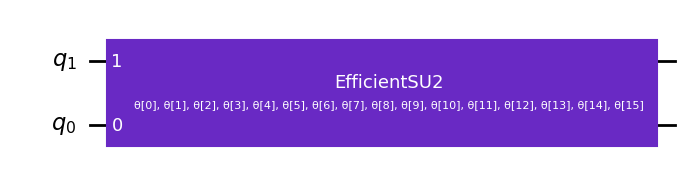

In [16]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw()

In [7]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [8]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [9]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [10]:
x0 = 2 * np.pi * np.random.random(num_params)

In [11]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 10000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 1 [Current cost: -0.14898027343749992]
Iters. done: 2 [Current cost: -0.33512431640624996]
Iters. done: 3 [Current cost: -0.340692919921875]
Iters. done: 4 [Current cost: -0.37933603515625003]
Iters. done: 5 [Current cost: -0.403387255859375]
Iters. done: 6 [Current cost: -0.6499095703125001]
Iters. done: 7 [Current cost: -0.406870068359375]
Iters. done: 8 [Current cost: -0.367927734375]
Iters. done: 9 [Current cost: -0.7193475097656251]
Iters. done: 10 [Current cost: -0.7789279785156249]
Iters. done: 11 [Current cost: -0.82311708984375]
Iters. done: 12 [Current cost: -0.294438671875]
Iters. done: 13 [Current cost: -0.6571487304687499]
Iters. done: 14 [Current cost: -0.7272251464843751]
Iters. done: 15 [Current cost: -0.8644370605468751]
Iters. done: 16 [Current cost: -0.8715665039062499]
Iters. done: 17 [Current cost: -0.8628453125]
Iters. done: 18 [Current cost: -0.850145068359375]
Iters. done: 19 [Current cost: -0.95717548828125]
Iters. done: 20 [Current cost: -1.080699

In [14]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.2659535644531252
       x: [ 3.589e+00  1.931e+00 ...  5.935e+00  3.303e+00]
    nfev: 185
   maxcv: 0.0


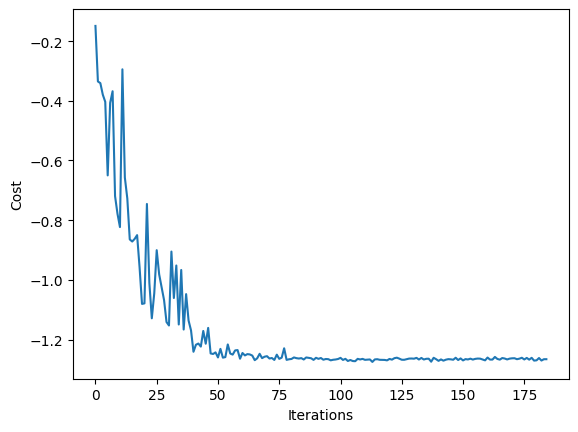

In [15]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [18]:
print(cost_history_dict['cost_history'])

[-0.14898027343749992, -0.33512431640624996, -0.340692919921875, -0.37933603515625003, -0.403387255859375, -0.6499095703125001, -0.406870068359375, -0.367927734375, -0.7193475097656251, -0.7789279785156249, -0.82311708984375, -0.294438671875, -0.6571487304687499, -0.7272251464843751, -0.8644370605468751, -0.8715665039062499, -0.8628453125, -0.850145068359375, -0.95717548828125, -1.080699462890625, -1.078808251953125, -0.745680712890625, -1.010457080078125, -1.1288801757812499, -1.04478056640625, -0.900599462890625, -0.9816268066406248, -1.0256400390624998, -1.0679582031250001, -1.14135205078125, -1.15296982421875, -0.905209423828125, -1.060864453125, -0.9518933593749999, -1.149590478515625, -0.9669365722656251, -1.1664979980468748, -1.04782763671875, -1.13637685546875, -1.16937041015625, -1.2410306152343749, -1.2175131347656252, -1.21347197265625, -1.2236979003906248, -1.1712010253906249, -1.21414443359375, -1.1610901855468752, -1.2466016601562502, -1.2484448730468751, -1.2430865234375

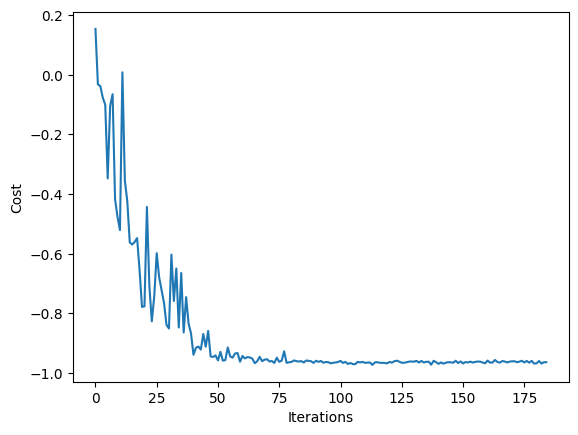

In [20]:
energy = np.array(cost_history_dict['cost_history']) + 0.3023869942
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), energy)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()